In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency

### Import Data

In [2]:
applicant_details = pd.read_csv('Loan_default.csv')

#### Data Exploration

In [3]:
pd.options.display.max_columns = None
applicant_details.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [4]:
applicant_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [5]:
applicant_details.isna().sum()

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

In [6]:
# Drop LoanID column as it's not required (This does not add any value in terms of differentiting the good and bad)
applicant_details.drop(['LoanID'],axis=1,inplace=True)

#### Train-Test Split
     Dependent (target variable --> Default(1-default and 0-non default))

In [7]:
# Split the data into train and test, also ensure the proportion of default are equal in both the sets.
X = applicant_details.drop('Default', axis = 1)
y = applicant_details['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

##### Data Cleaning if any required
    - check the distinct value of all the catogorical variable.

In [8]:
applicant_details['Education'].unique()

array(["Bachelor's", "Master's", 'High School', 'PhD'], dtype=object)

In [9]:
applicant_details.columns

Index(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education',
       'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents',
       'LoanPurpose', 'HasCoSigner', 'Default'],
      dtype='object')

In [10]:
for col in applicant_details.columns:
    if applicant_details[col].dtype == 'object':
        print(col," : ",applicant_details[col].unique())

Education  :  ["Bachelor's" "Master's" 'High School' 'PhD']
EmploymentType  :  ['Full-time' 'Unemployed' 'Self-employed' 'Part-time']
MaritalStatus  :  ['Divorced' 'Married' 'Single']
HasMortgage  :  ['Yes' 'No']
HasDependents  :  ['Yes' 'No']
LoanPurpose  :  ['Other' 'Auto' 'Business' 'Home' 'Education']
HasCoSigner  :  ['Yes' 'No']


All the catogorical columns have quiet few distinct values which mean we will not face high cardinality.

In [11]:
applicant_details[col].dtype

dtype('int64')

##### Lets check for collinearity
    1. Catogorical feature -  Chi-Squared test of independance
    2. Pearson's corelation

In [12]:
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

In [13]:
# define an empty dictionary to store chi-squared test results.
chi2_result = {}

for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_result.setdefault('Feature',[]).append(column)
    chi2_result.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_result)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,Education,0.0
1,EmploymentType,0.0
2,MaritalStatus,0.0
3,HasMortgage,0.0
4,HasDependents,0.0
5,LoanPurpose,0.0
6,HasCoSigner,0.0


All of this catogorical variable have p-value which is lower the 0.05. we can use them

In [14]:
import numpy as np

Text(0.5, 1.0, 'Pearson correlation')

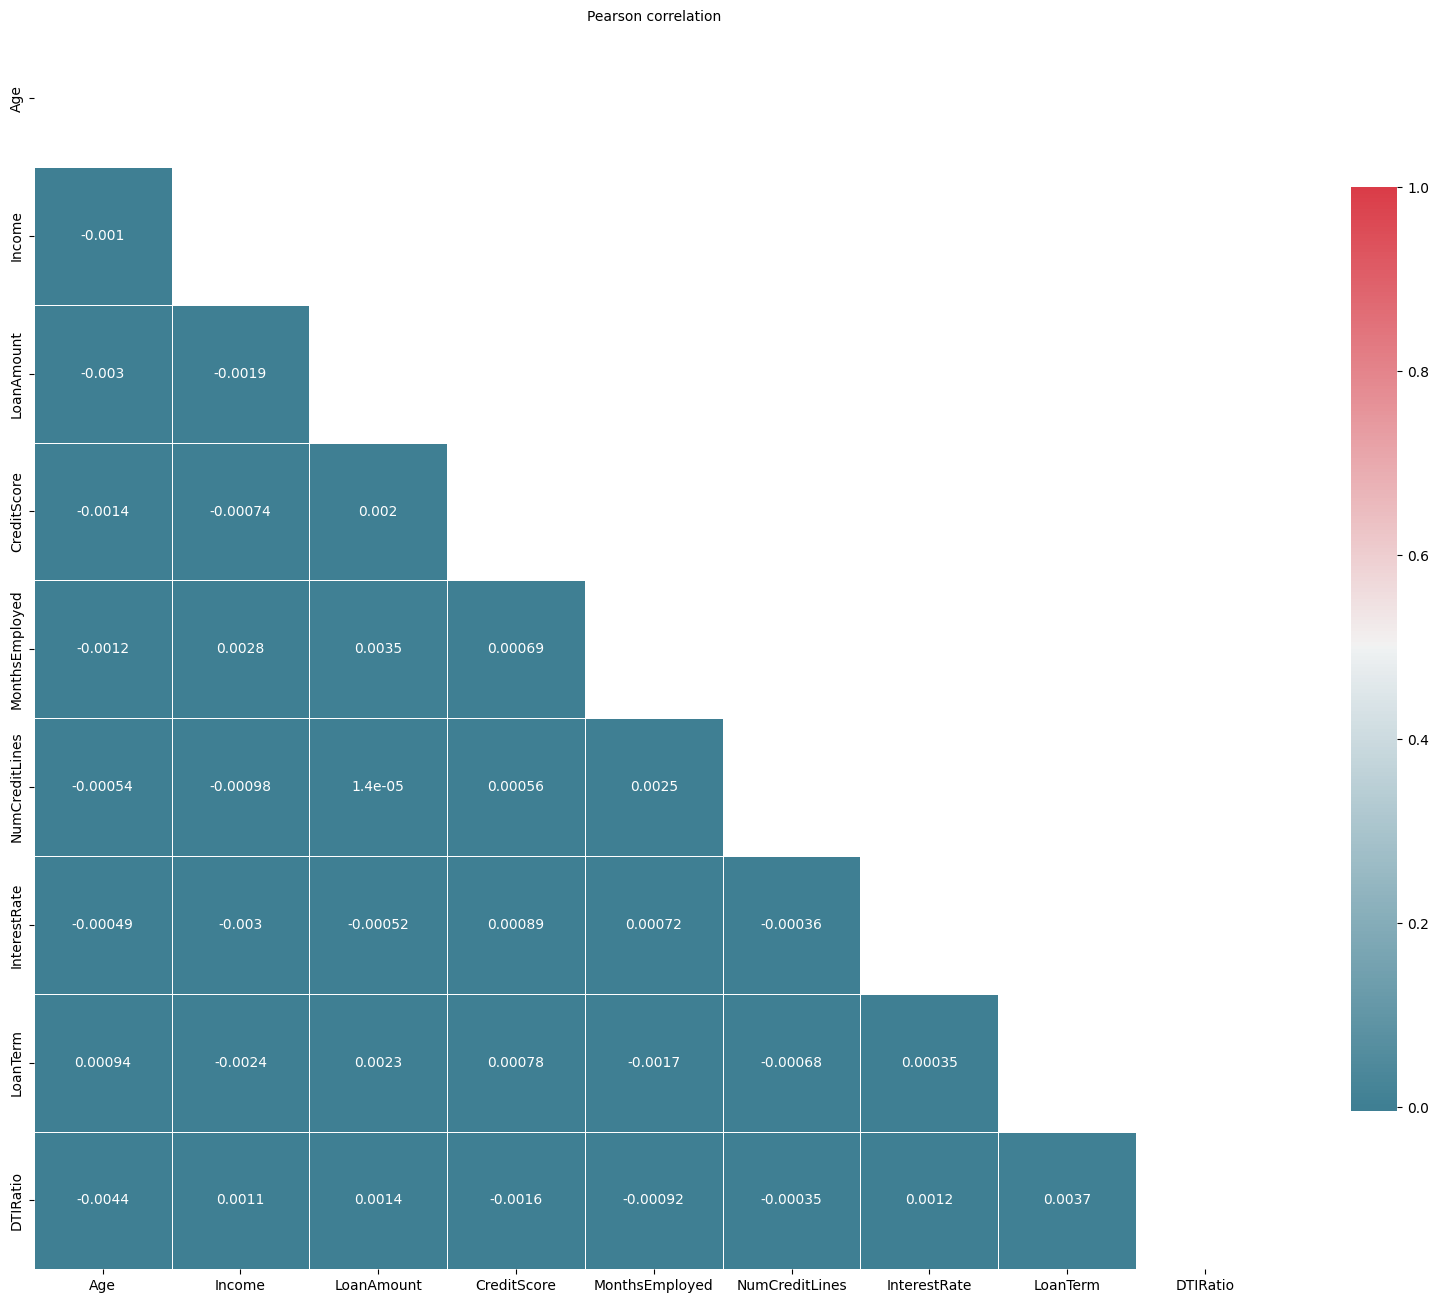

In [15]:
corrmat = X_train_num.corr()
mask = np.triu(np.ones_like(corrmat, dtype=bool))
f, ax = plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corrmat, cmap= cmap, mask= mask, vmax=1, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .6},annot=True)

plt.title("Pearson correlation", fontsize =10)

This suggest that there is no multicollinearity with other features

If we had done some data cleaning or missing value imputation or any kind of data manipulation  on train data set then remember to perform the same steps on test data set as well, Generally we do this to avoid data leakage problem.

#### Weight-of-Evidence (WoE) Binning:
    1. Fine classing
    2. Coarse classing

In [16]:
X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()
X_test_prepr = X_test.copy()
y_test_prepr = y_test.copy()

In [68]:
X_train_cat.columns.values[1]

'EmploymentType'

In [70]:
df = pd.concat([applicant_details.groupby('Education', as_index = False)['Default'].count(),
                    applicant_details.groupby('Education', as_index = False)['Default'].mean()], axis = 1)

In [71]:
df

,Education,Default,Education,Default
0,Bachelor's,64366,Bachelor's,0.121011
1,High School,63903,High School,0.128789
2,Master's,63541,Master's,0.108717
3,PhD,63537,PhD,0.105860


In [17]:
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [18]:
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [19]:
sns.set_theme()
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

In [20]:
df_temp = woe_ordered_continuous(X_train_prepr, 'Education', y_train_prepr)
df_temp

,Education,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Bachelor's,51537,0.120632,0.252290,6217.0,45320.0,0.262077,0.251004,0.043172,NaN,NaN,0.007595
1,High School,51122,0.128516,0.250258,6570.0,44552.0,0.276958,0.246750,0.115489,0.007884,0.072318,0.007595
2,Master's,50695,0.108906,0.248168,5521.0,45174.0,0.232738,0.250195,-0.072330,0.019610,0.187819,0.007595
3,PhD,50923,0.106317,0.249284,5414.0,45509.0,0.228227,0.252051,-0.099289,0.002589,0.026959,0.007595


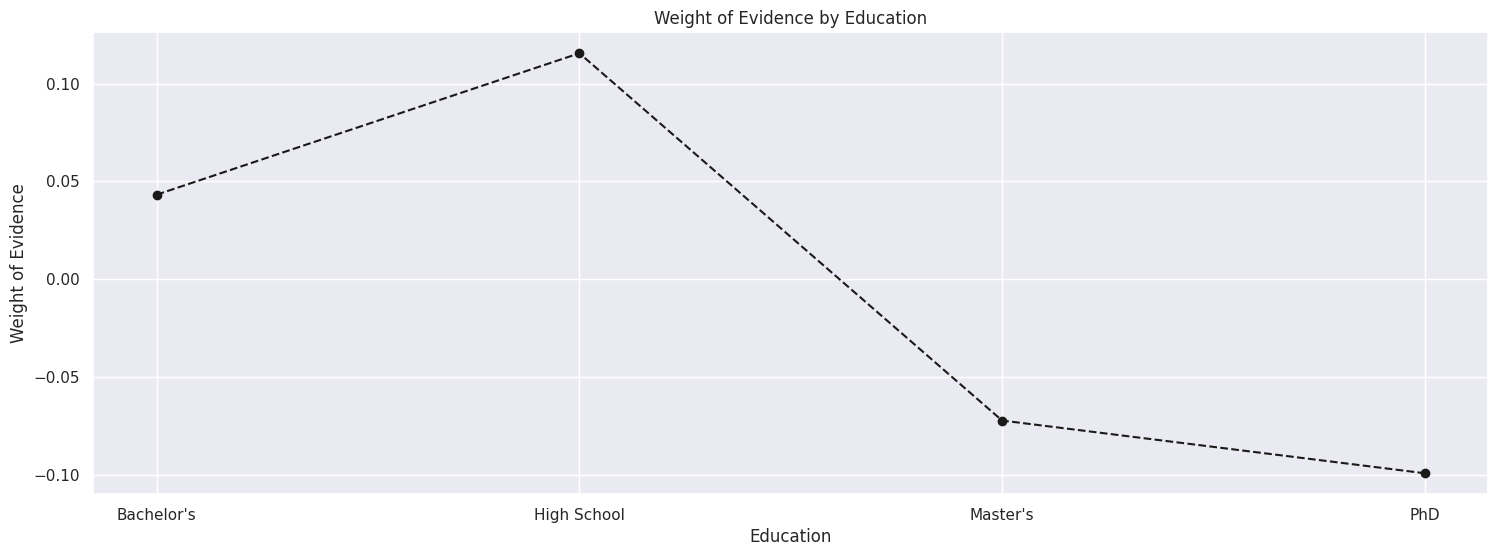

In [21]:
plot_by_woe(df_temp)

In [22]:
df_temp = woe_ordered_continuous(X_train_prepr, 'EmploymentType', y_train_prepr)
df_temp

,EmploymentType,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Full-time,50932,0.094597,0.249328,4818.0,46114.0,0.203103,0.255401,-0.229125,NaN,NaN,0.02051
1,Part-time,51324,0.119126,0.251247,6114.0,45210.0,0.257735,0.250395,0.028895,0.024529,0.258021,0.02051
2,Self-employed,51024,0.115259,0.249778,5881.0,45143.0,0.247913,0.250024,-0.008476,0.003866,0.037371,0.02051
3,Unemployed,50997,0.135479,0.249646,6909.0,44088.0,0.291249,0.244180,0.176270,0.020219,0.184746,0.02051


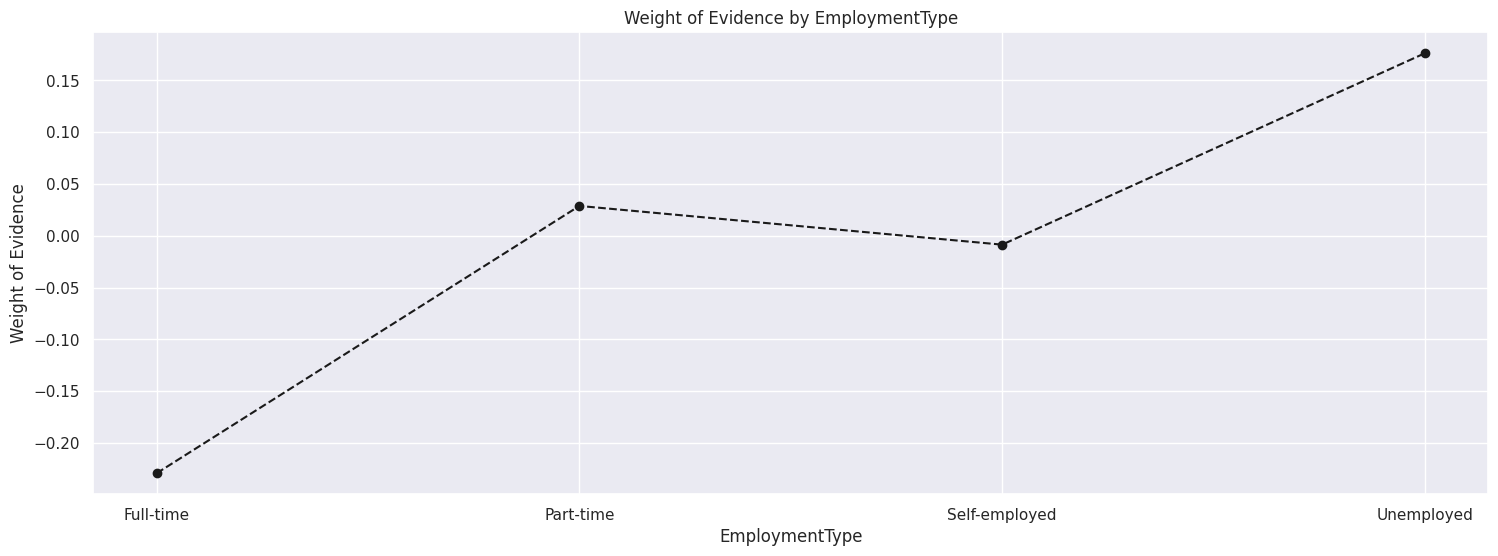

In [23]:
plot_by_woe(df_temp)

In [24]:
X_train.columns

Index(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education',
       'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents',
       'LoanPurpose', 'HasCoSigner'],
      dtype='object')

In [25]:
df_temp = woe_ordered_continuous(X_train_prepr, 'MaritalStatus', y_train_prepr)
df_temp

,MaritalStatus,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Divorced,68032,0.124882,0.333038,8496.0,59536.0,0.358149,0.329739,0.082647,NaN,NaN,0.006637
1,Married,68261,0.104994,0.334159,7167.0,61094.0,0.302125,0.338368,-0.113294,0.019888,0.195941,0.006637
2,Single,67984,0.118543,0.332803,8059.0,59925.0,0.339727,0.331893,0.023328,0.013549,0.136622,0.006637


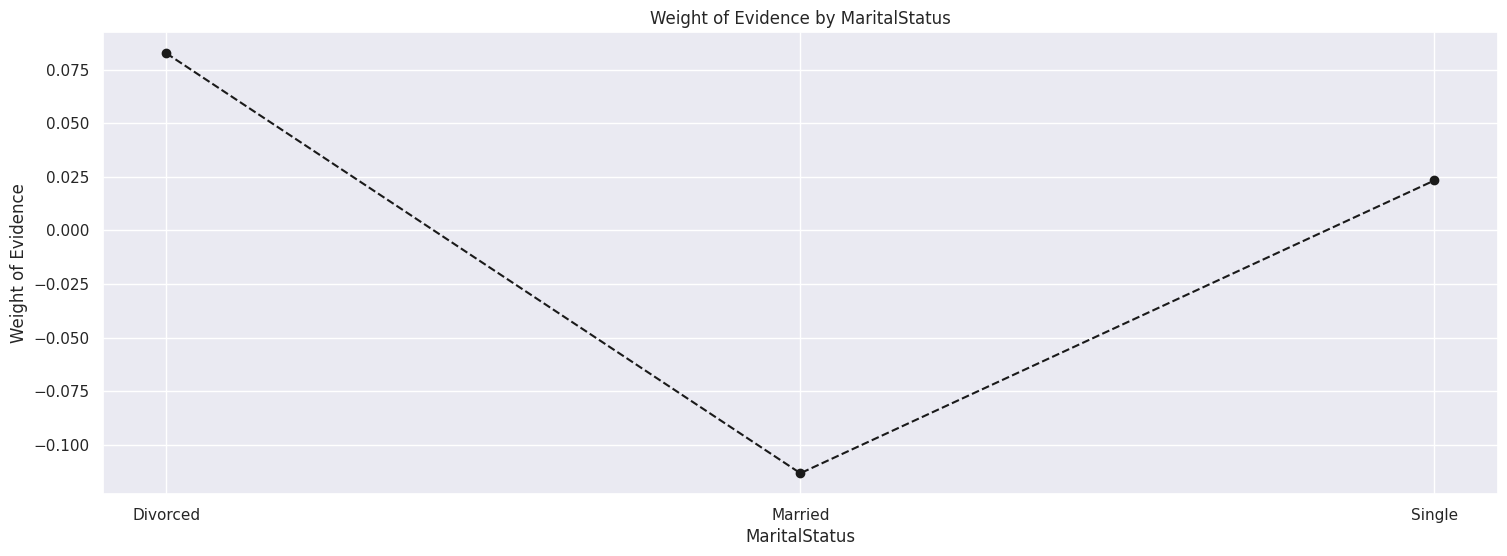

In [26]:
plot_by_woe(df_temp)

In [27]:
df_temp = woe_ordered_continuous(X_train_prepr, 'HasMortgage', y_train_prepr)
df_temp

,HasMortgage,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,No,102094,0.123288,0.499782,12587.0,89507.0,0.530605,0.495733,0.067980,NaN,NaN,0.00487
1,Yes,102183,0.108971,0.500218,11135.0,91048.0,0.469395,0.504267,-0.071661,0.014317,0.139641,0.00487


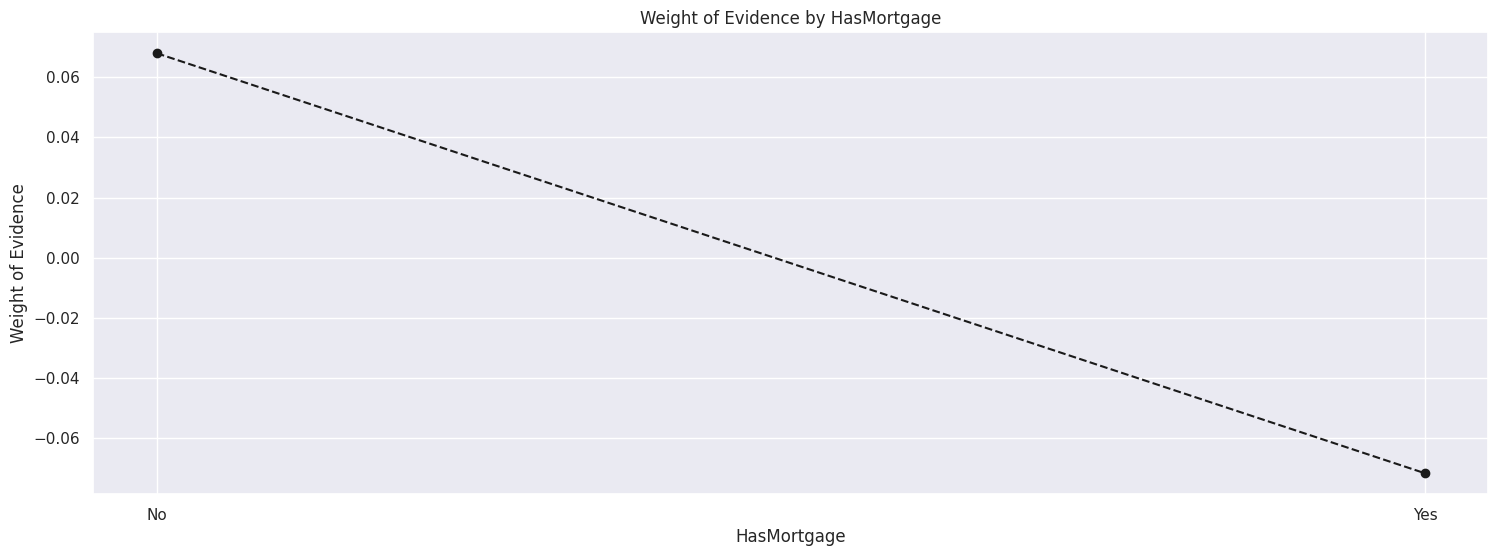

In [28]:
plot_by_woe(df_temp)

In [29]:
df_temp = woe_ordered_continuous(X_train_prepr, 'HasDependents', y_train_prepr)
df_temp

,HasDependents,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,No,102001,0.127607,0.499327,13016.0,88985.0,0.548689,0.492842,0.107344,NaN,NaN,0.01251
1,Yes,102276,0.104678,0.500673,10706.0,91570.0,0.451311,0.507158,-0.116667,0.022929,0.224011,0.01251


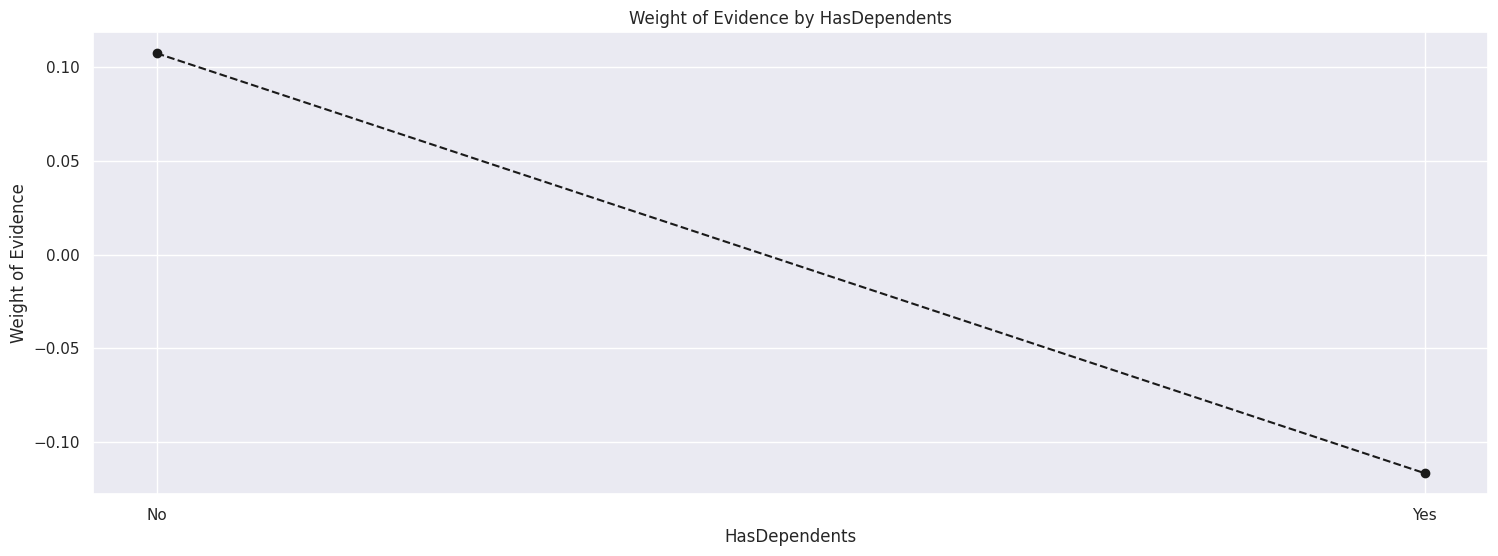

In [30]:
plot_by_woe(df_temp)

In [31]:
df_temp = woe_ordered_continuous(X_train_prepr, 'LoanPurpose', y_train_prepr)
df_temp

,LoanPurpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Auto,40702,0.118373,0.199249,4818.0,35884.0,0.203103,0.198743,0.021700,NaN,NaN,0.005125
1,Business,41008,0.124147,0.200747,5091.0,35917.0,0.214611,0.198926,0.075896,0.005774,0.054196,0.005125
2,Education,40823,0.118389,0.199841,4833.0,35990.0,0.203735,0.199330,0.021859,0.005757,0.054037,0.005125
3,Home,40996,0.102522,0.200688,4203.0,36793.0,0.177177,0.203777,-0.139877,0.015867,0.161735,0.005125
4,Other,40748,0.117233,0.199474,4777.0,35971.0,0.201374,0.199225,0.010732,0.014711,0.150609,0.005125


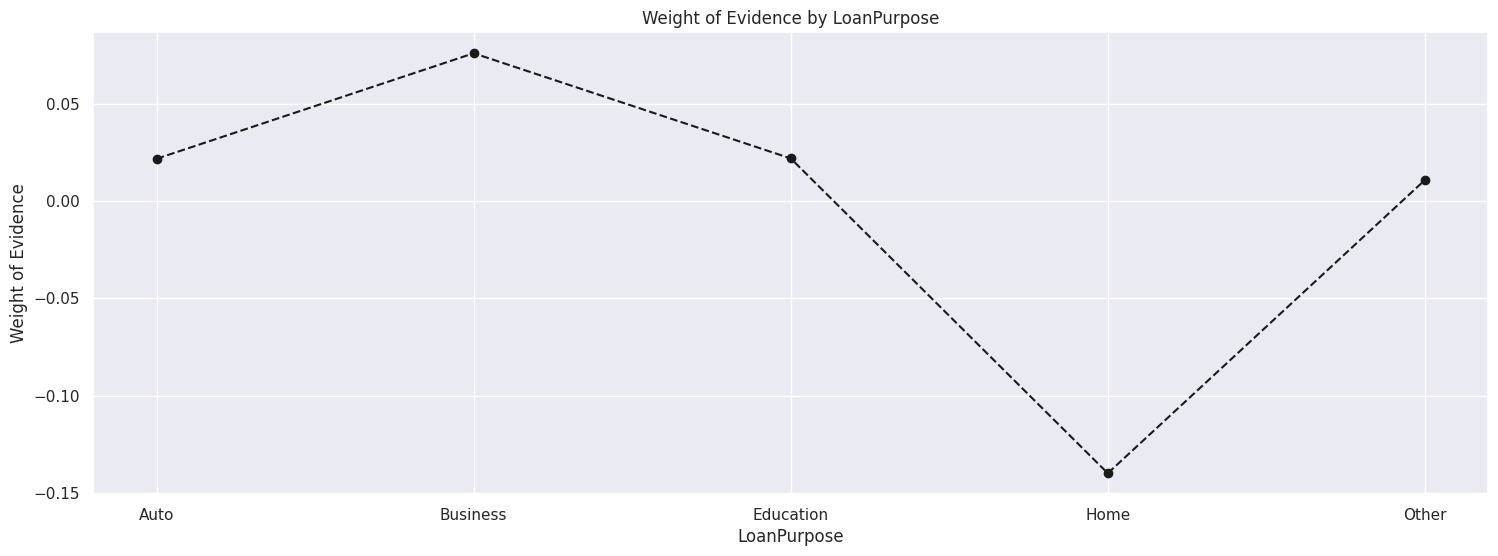

In [32]:
plot_by_woe(df_temp)

In [33]:
df_temp = woe_ordered_continuous(X_train_prepr, 'HasCoSigner', y_train_prepr)
df_temp

,HasCoSigner,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,No,102114,0.128131,0.49988,13084.0,89030.0,0.551556,0.493091,0.112049,NaN,NaN,0.013716
1,Yes,102163,0.104128,0.50012,10638.0,91525.0,0.448444,0.506909,-0.122547,0.024004,0.234596,0.013716


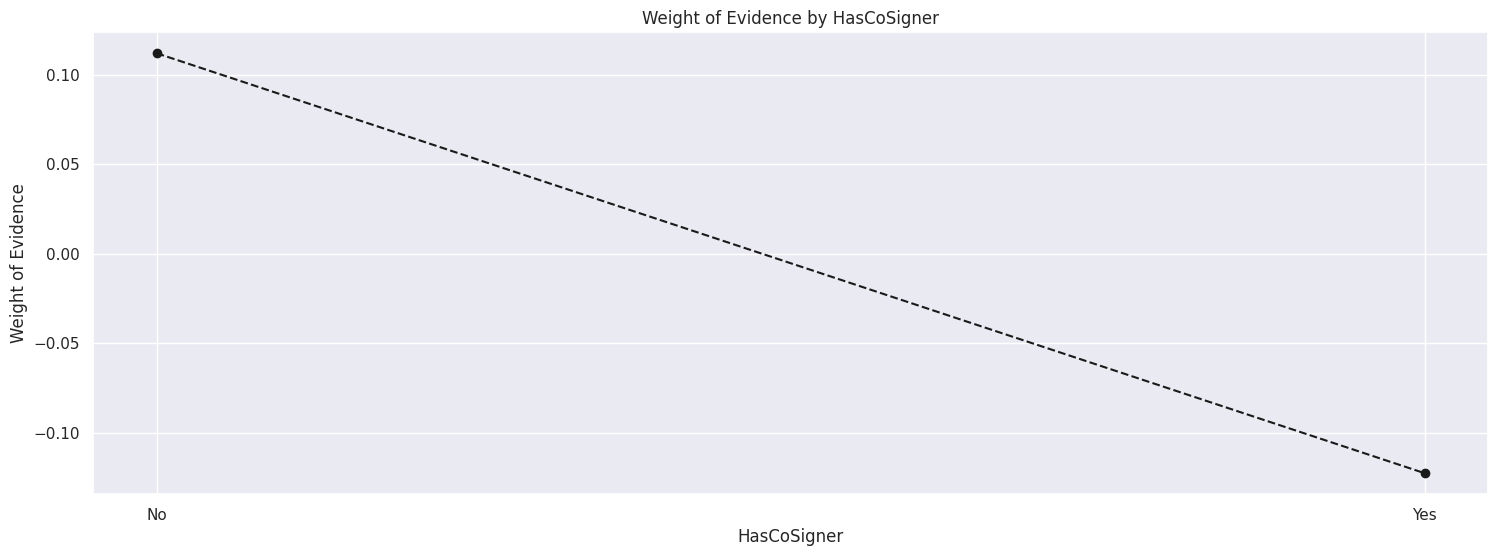

In [34]:
plot_by_woe(df_temp)

#### Numerical Variable

In [74]:
# fine-classing using the 'cut' method, given the large number of unique values
X_train_prepr['Age_factor'] = pd.cut(X_train_prepr['Age'],5)
df_temp = woe_ordered_continuous(X_train_prepr, 'Age_factor', y_train_prepr)
df_temp

/tmp/ipykernel_2629531/2207244585.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
/tmp/ipykernel_2629531/2207244585.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)


,Age_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(17.949, 28.2]",42956,0.199669,0.210283,8577.0,34379.0,0.361563,0.190407,0.641271,NaN,NaN,0.274422
1,"(28.2, 38.4]",39526,0.146106,0.193492,5775.0,33751.0,0.243445,0.186929,0.264161,0.053563,0.377110,0.274422
2,"(38.4, 48.6]",39152,0.104056,0.191661,4074.0,35078.0,0.171739,0.194279,-0.123316,0.042050,0.387477,0.274422
3,"(48.6, 58.8]",39550,0.076688,0.193610,3033.0,36517.0,0.127856,0.202249,-0.458593,0.027368,0.335277,0.274422
4,"(58.8, 69.0]",43093,0.052514,0.210954,2263.0,40830.0,0.095397,0.226136,-0.863093,0.024173,0.404500,0.274422


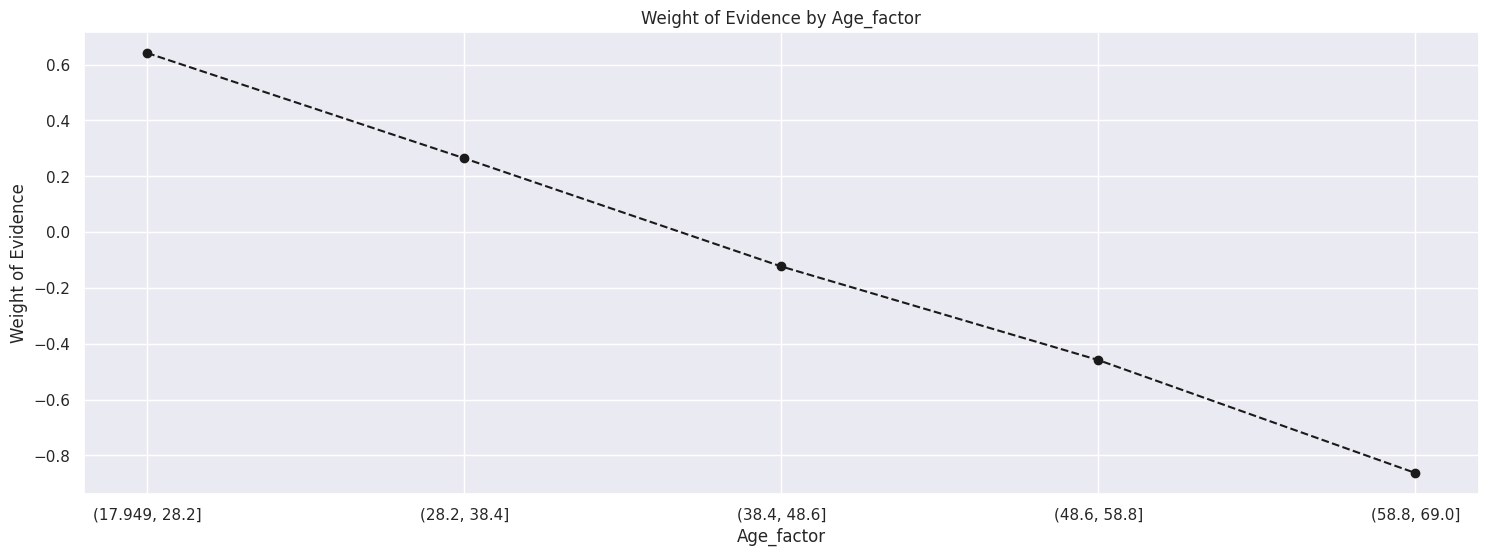

In [75]:
plot_by_woe(df_temp)

In [37]:
X_train_prepr['Income_factor'] = pd.cut(X_train_prepr['Income'],10)
df_temp = woe_ordered_continuous(X_train_prepr, 'Income_factor', y_train_prepr)
df_temp

/tmp/ipykernel_2629531/2207244585.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
/tmp/ipykernel_2629531/2207244585.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)


,Income_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(14865.001, 28499.9]",20471,0.225539,0.100212,4617.0,15854.0,0.194629,0.087807,0.795956,NaN,NaN,0.125332
1,"(28499.9, 41999.8]",20304,0.146474,0.099394,2974.0,17330.0,0.125369,0.095982,0.267101,0.079065,0.528855,0.125332
2,"(41999.8, 55499.7]",20485,0.117696,0.100281,2411.0,18074.0,0.101636,0.100102,0.015200,0.028778,0.251902,0.125332
3,"(55499.7, 68999.6]",20323,0.108006,0.099487,2195.0,18128.0,0.092530,0.100402,-0.081643,0.009690,0.096843,0.125332
4,"(68999.6, 82499.5]",20534,0.099104,0.100520,2035.0,18499.0,0.085785,0.102456,-0.177588,0.008902,0.095945,0.125332
5,"(82499.5, 95999.4]",20408,0.098099,0.099904,2002.0,18406.0,0.084394,0.101941,-0.188897,0.001005,0.011309,0.125332
6,"(95999.4, 109499.3]",20387,0.093981,0.099801,1916.0,18471.0,0.080769,0.102301,-0.236330,0.004117,0.047432,0.125332
7,"(109499.3, 122999.2]",20495,0.092510,0.100329,1896.0,18599.0,0.079926,0.103010,-0.253729,0.001471,0.017399,0.125332
8,"(122999.2, 136499.1]",20336,0.091168,0.099551,1854.0,18482.0,0.078155,0.102362,-0.269819,0.001342,0.016090,0.125332
9,"(136499.1, 149999.0]",20534,0.088731,0.100520,1822.0,18712.0,0.076806,0.103636,-0.299598,0.002437,0.029778,0.125332


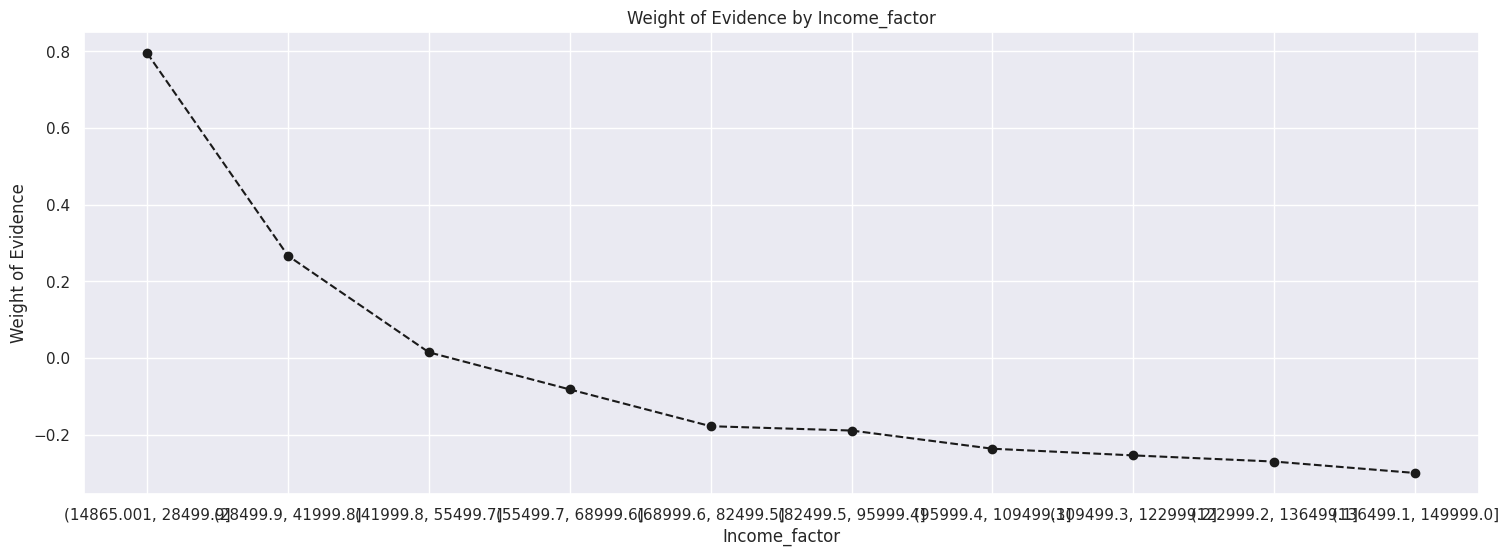

In [38]:
plot_by_woe(df_temp)

##### There is Python library available called as 'scorecardpy' which is usefull for creating the scorecard. It has built in functions for WoE binning and applying those woe values(replacing the bin with its corresponding WoE value) and then we can perform the logistic regression. It also has a function to convert the LG model's coeffient to score. We will use 'scorecardpy'

In [39]:
import scorecardpy as sc

In [41]:
bins = sc.woebin(applicant_details, y="Default")

[INFO] creating woe binning ...


/home/amol-murme/PYTHON TEAM KT/venv/lib/python3.11/site-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/home/amol-murme/PYTHON TEAM KT/venv/lib/python3.11/site-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/home/amol-murme/PYTHON TEAM KT/venv/lib/python3.11/site-packages/scorecardpy/condition_fun.py:40: UserWarning: Could not infer format, so each element

Binning on 255347 rows and 17 columns in 00:00:13


In [42]:
bins

{'LoanTerm':    variable          bin   count  count_distr   good    bad   badprob  \
 0  LoanTerm  [-inf,24.0)   50957     0.199560  45037   5920  0.116176   
 1  LoanTerm  [24.0,36.0)   51009     0.199763  45088   5921  0.116078   
 2  LoanTerm  [36.0,60.0)  102227     0.400345  90398  11829  0.115713   
 3  LoanTerm   [60.0,inf)   51154     0.200331  45171   5983  0.116961   
 
         woe        bin_iv  total_iv breaks  is_special_values  
 0  0.000469  4.387960e-08   0.00002   24.0              False  
 1 -0.000494  4.873696e-08   0.00002   36.0              False  
 2 -0.004051  6.560349e-06   0.00002   60.0              False  
 3  0.008084  1.313132e-05   0.00002    inf              False  ,
 'HasMortgage':       variable  bin   count  count_distr    good    bad   badprob       woe  \
 0  HasMortgage  Yes  127677     0.500014  113785  13892  0.108806 -0.073381   
 1  HasMortgage   No  127670     0.499986  111909  15761  0.123451  0.069469   
 
      bin_iv  total_iv breaks  is

In [43]:
# converting train and test into woe values
train_woe = sc.woebin_ply(X_train, bins)
test_woe = sc.woebin_ply(X_test, bins)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [44]:
# Building the logistic regression Model
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(train_woe,y_train_prepr)
lr.coef_
# lr.intercept_

array([[1.08623638, 0.        , 1.0987882 , 1.05458484, 1.12462452,
        1.07055423, 1.12292837, 1.08318175, 1.12051324, 1.07748986,
        1.15544391, 1.12248793, 1.09078084, 0.96620966, 1.10328811,
        1.06064962]])

In [45]:
# predicted proability
train_pred = lr.predict_proba(train_woe)[:,1]
test_pred = lr.predict_proba(test_woe)[:,1]

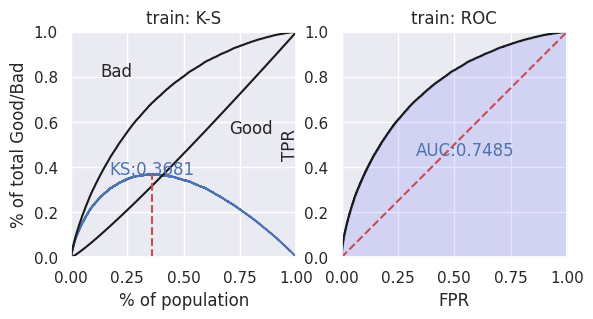

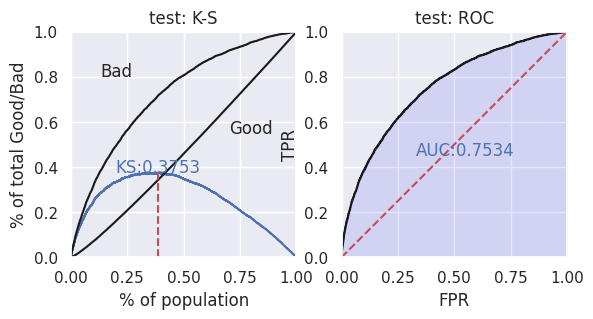

In [46]:
# performance ks & roc ------
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

In [47]:
# derived the scores.
card = sc.scorecard(bins, lr, X_train.columns)

In [78]:
card

{'basepoints':      variable  bin  points
 0  basepoints  NaN   534.0,
 'Age':    variable          bin  points
 26      Age  [-inf,29.0)   -51.0
 27      Age  [29.0,37.0)   -24.0
 28      Age  [37.0,43.0)    -2.0
 29      Age  [43.0,57.0)    25.0
 30      Age   [57.0,inf)    66.0,
 'LoanAmount':       variable                  bin  points
 31  LoanAmount       [-inf,90000.0)    27.0
 32  LoanAmount   [90000.0,145000.0)     5.0
 33  LoanAmount  [145000.0,195000.0)   -10.0
 34  LoanAmount       [195000.0,inf)   -28.0,
 'CreditScore':        variable            bin  points
 49  CreditScore   [-inf,370.0)   -14.0
 50  CreditScore  [370.0,530.0)    -5.0
 51  CreditScore  [530.0,600.0)    -0.0
 52  CreditScore  [600.0,710.0)     4.0
 53  CreditScore    [710.0,inf)    11.0,
 'MonthsEmployed':           variable           bin  points
 54  MonthsEmployed   [-inf,30.0)   -31.0
 55  MonthsEmployed   [30.0,56.0)    -8.0
 56  MonthsEmployed   [56.0,78.0)     9.0
 57  MonthsEmployed  [78.0,100.0)  

In [77]:
card = pd.DataFrame(card)

ValueError: If using all scalar values, you must pass an index

In [49]:
train_score = sc.scorecard_ply(X_train, card, print_step=0)
test_score = sc.scorecard_ply(X_test, card, print_step=0)

In [50]:
scores = sc.scorecard_ply(applicant_details,card,print_step=0)

/home/amol-murme/PYTHON TEAM KT/venv/lib/python3.11/site-packages/scorecardpy/scorecard.py:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_score.loc[:,'score'] = card_basepoints + dat_score.sum(axis=1)


/home/amol-murme/PYTHON TEAM KT/venv/lib/python3.11/site-packages/scorecardpy/perf.py:470: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dt_bae = dat.groupby(['ae','bin']).size().reset_index(name='N')\
/home/amol-murme/PYTHON TEAM KT/venv/lib/python3.11/site-packages/scorecardpy/perf.py:471: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(values='N', index='bin', columns='ae').fillna(0.9)\
/home/amol-murme/PYTHON TEAM KT/venv/lib/python3.11/site-packages/scorecardpy/perf.py:511: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain c

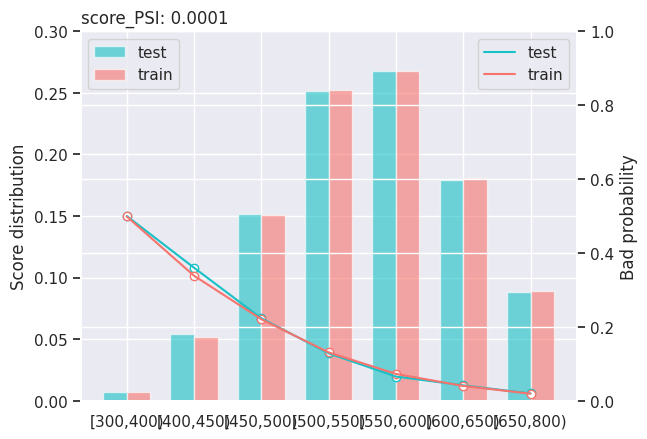

{'psi':   variable       PSI
 0    score  0.000141,
 'pic': {'score': <Figure size 640x480 with 2 Axes>}}

In [51]:
# psi
sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test}
)

In [52]:
scores = pd.concat([scores,applicant_details['Default']],axis=1)

In [53]:
scores

,score,Default
0,617.0,0
1,661.0,0
2,481.0,1
3,546.0,0
4,579.0,0
...,...,...
255342,478.0,0
255343,476.0,1
255344,616.0,0
255345,522.0,0


In [54]:
scores.describe()

,score,Default
count,255347.000000,255347.000000
mean,556.160703,0.116128
std,68.038132,0.320379
min,314.000000,0.000000
25%,509.000000,0.000000
50%,556.000000,0.000000
75%,604.000000,0.000000
max,796.000000,1.000000


In [55]:
cutoff_scores = list(range(250,750, 25))

In [56]:
account_counts = [len(scores[scores['score'] > cutoff]) for cutoff in cutoff_scores]

# Calculate count of defaulted accounts among those above the cutoff score
defaulted_counts = [scores[(scores['score'] > cutoff) & (scores['Default'] == 1)]['Default'].count() for cutoff in cutoff_scores]

# Create a DataFrame to display the results
result_scores = pd.DataFrame({
    'cutoff_score': cutoff_scores[:-1],  # Exclude the last cutoff as it's just an upper limit
    'Total' : scores.shape[0],
    'Approved': account_counts[:-1],
    'Defaulted': defaulted_counts[:-1],
})
result_scores['Rejecte'] = result_scores['Total'] - result_scores['Approved']
result_scores['Approval_rate'] = result_scores['Approved'] / result_scores['Total']
result_scores['Default_rate'] = result_scores['Defaulted'] / result_scores['Approved']

In [57]:
result_scores

,cutoff_score,Total,Approved,Defaulted,Rejecte,Approval_rate,Default_rate
0,250,255347,255347,29653,0,1.000000,0.116128
1,275,255347,255347,29653,0,1.000000,0.116128
2,300,255347,255347,29653,0,1.000000,0.116128
3,325,255347,255343,29650,4,0.999984,0.116118
4,350,255347,255286,29618,61,0.999761,0.116019
5,375,255347,254892,29397,455,0.998218,0.115331
6,400,255347,253335,28666,2012,0.992121,0.113155
7,425,255347,248814,26887,6533,0.974415,0.108061
8,450,255347,239601,23984,15746,0.938335,0.100100
9,475,255347,223745,20002,31602,0.876239,0.089396


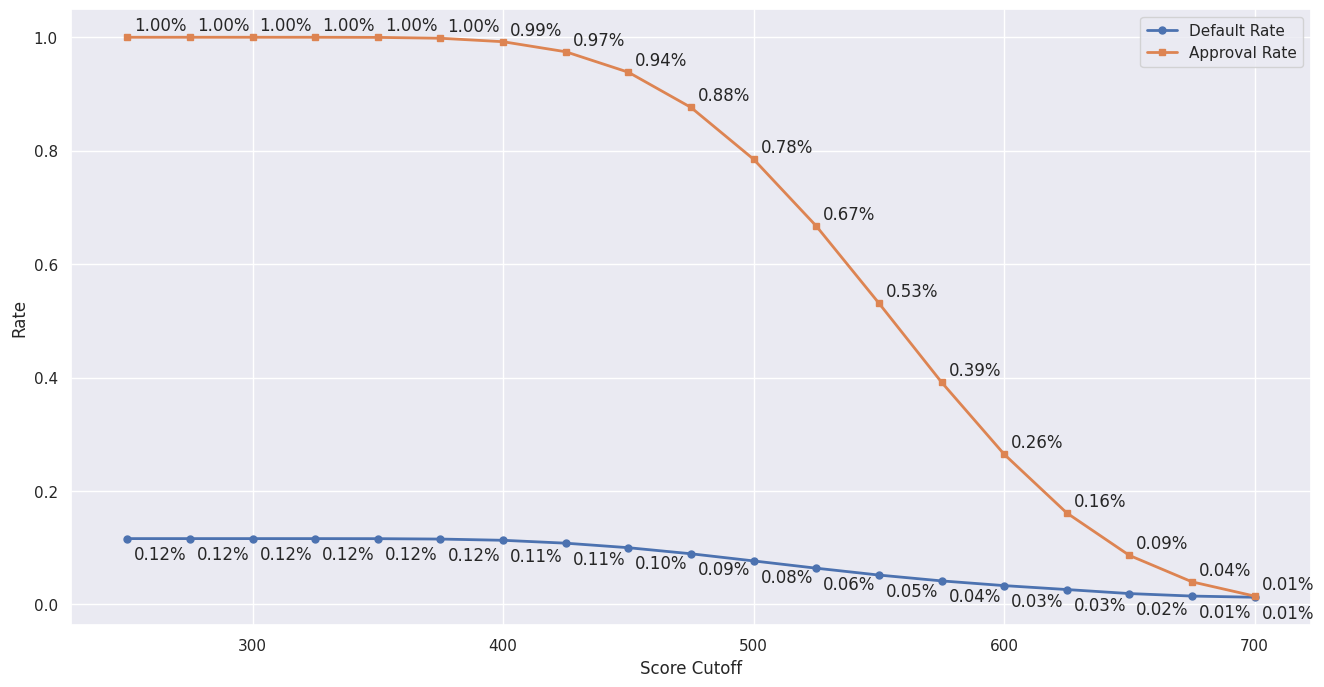

In [59]:
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the Approval Rate and Default Rate lines with markers
ax.plot(result_scores['cutoff_score'], result_scores['Default_rate'], label='Default Rate', marker='o', markersize=5, linewidth=2)
ax.plot(result_scores['cutoff_score'], result_scores['Approval_rate'], label='Approval Rate', marker='s', markersize=5, linewidth=2)


# Add data labels for the Approval Rate and Default Rate lines
for i, rate in enumerate(result_scores['Approval_rate']):
    ax.annotate('{:.2f}%'.format(rate), xy=(result_scores['cutoff_score'][i], rate), xytext=(5, 5), textcoords='offset points')

for i, rate in enumerate(result_scores['Default_rate']):
    ax.annotate('{:.2f}%'.format(rate), xy=(result_scores['cutoff_score'][i], rate), xytext=(5, -15), textcoords='offset points')

# Set axis labels and legend
ax.set_xlabel('Score Cutoff')
ax.set_ylabel('Rate')
ax.legend()

plt.show()
